#**Практическое задание №1**

Установка необходимых пакетов:

In [ ]:
# !pip install -q tqdm
# !pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [ ]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [ ]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown
import datetime

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import utils
from torch.functional import F
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [ ]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        # check if dataset is already downloaded
        if not Path(f'{name}.npz').exists():
            url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
            print(f'Downloading dataset {self.name} from {url}.')
            output = f'{name}.npz'
            gdown.download(url, output, quiet=False)
        
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]
  
    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]
    
    def __len__(self):
        return self.n_files
    
    # def __getitem__(self, idx):
    #     if self.is_loaded:
    #         img = self.images[idx]
    #         label = self.labels[idx]
    #         # Преобразование в тензор
    #         img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # (H, W, C) -> (C, H, W)
    #         label_tensor = torch.tensor(label, dtype=torch.long)
    #         return img_tensor, label_tensor
    def __getitem__(self, idx):
        if self.is_loaded:
            img = self.images[idx]
            label = self.labels[idx]
            # Преобразование в тензор и нормализация
            img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0  # Нормализация в диапазон [0, 1]
            label_tensor = torch.tensor(label, dtype=torch.long)
            return img_tensor, label_tensor

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

In [ ]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [ ]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            # First block
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Second block
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Third block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Fourth block
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [ ]:
class Model:
    def __init__(self, 
                 model: nn.Module, 
                 criterion: nn.Module = nn.CrossEntropyLoss(), 
                 optimizer_fn: optim.Optimizer = optim.Adam, 
                 optimizer_params: dict = {"lr": 0.001}, 
                 scheduler_type: str = "constant", 
                 scheduler_params: dict = None, 
                 log_dir: str = "runs/model",
                 auto_tune=False,
                 tune_params=None):
        """
        Initialize the Model class with custom model, criterion, optimizer, and scheduler.

        :param model: PyTorch model instance (e.g., SimpleCNN).
        :param criterion: Loss function (default: CrossEntropyLoss).
        :param optimizer_fn: Optimizer class (e.g., optim.Adam).
        :param optimizer_params: Parameters for the optimizer (default: {"lr": 0.001}).
        :param scheduler_type: Type of learning rate scheduler ("constant", "step", "reduce_on_plateau").
        :param scheduler_params: Parameters for the scheduler (e.g., step_size, factor).
        :param log_dir: Directory for TensorBoard logs.
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device {self.device}")
        
        self.model = model.to(self.device)
        self.criterion = criterion
        self.optimizer = optimizer_fn(self.model.parameters(), **optimizer_params)
        self.best_val_loss = float('inf')
        self.conf_matrix = None

        # Configure scheduler based on type
        if scheduler_type == "step":
            self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, **scheduler_params)
        elif scheduler_type == "reduce_on_plateau":
            self.scheduler = ReduceLROnPlateau(self.optimizer, **scheduler_params)
        else:
            self.scheduler = None  # Constant learning rate

        self.writer = SummaryWriter(log_dir)
        print(f"Model initialized. Device: {self.device}")
        print(next(self.model.parameters()).device)

    def train(self, train_loader, val_loader=None, epochs=10, early_stopping_patience=5, save_path="best_model.pth"):
        """
        Train the model with optional validation and learning rate scheduling.

        :param train_loader: DataLoader for training data.
        :param val_loader: DataLoader for validation data (optional).
        :param epochs: Number of epochs to train.
        :param early_stopping_patience: Patience for early stopping.
        :param save_path: Path to save the best model.
        """
        best_val_loss = float('inf')
        no_improvement_epochs = 0

        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            train_loss = running_loss / len(train_loader)
            train_accuracy = 100. * correct / total
            print(f"Epoch [{epoch + 1}/{epochs}] - Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
            self.writer.add_scalar("Training Loss", train_loss, epoch + 1)
            self.writer.add_scalar("Training Accuracy", train_accuracy, epoch + 1)

            # Validation
            if val_loader:
                val_loss, val_accuracy = self.evaluate(val_loader)
                print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
                self.writer.add_scalar("Validation Loss", val_loss, epoch + 1)
                self.writer.add_scalar("Validation Accuracy", val_accuracy, epoch + 1)

                # Early Stopping
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    no_improvement_epochs = 0
                    self.best_val_loss = best_val_loss
                    torch.save(self.model.state_dict(), save_path)
                    print(f"Saved new best model: {save_path}")
                else:
                    no_improvement_epochs += 1
                    if no_improvement_epochs >= early_stopping_patience:
                        print("Early stopping triggered.")
                        break
            self.writer.flush()
            # Adjust learning rate if scheduler is used
            if self.scheduler:
                if isinstance(self.scheduler, ReduceLROnPlateau):
                    self.scheduler.step(val_loss)
                else:
                    self.scheduler.step()

    def evaluate(self, data_loader, plot_conf_matrix=False):
        """
        Evaluate the model on a dataset.

        :param data_loader: DataLoader for evaluation data.
        :return: Average loss and accuracy.
        """
        self.model.eval()
        correct = 0
        total = 0
        running_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in tqdm(data_loader, desc="Evaluating"):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = 100. * correct / total
        avg_loss = running_loss / len(data_loader)
        if plot_conf_matrix:
            self.conf_matrix = self._compute_confusion_matrix(all_labels, all_preds)

        return avg_loss, accuracy
    
    def _compute_confusion_matrix(self, true_labels, predicted_labels):
        """
        Compute confusion matrix and plot it.
        """
        conf_matrix = confusion_matrix(true_labels, predicted_labels)
        disp = ConfusionMatrixDisplay(conf_matrix, display_labels=np.arange(len(conf_matrix)))
        disp.plot(cmap=plt.cm.Blues, values_format="d")
        plt.title("Confusion Matrix")
        plt.show()
        return conf_matrix

    def plot_metrics(self, conf_matrix):
        """
        Plot confusion matrix as a heatmap.
        """
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=TISSUE_CLASSES, yticklabels=TISSUE_CLASSES)
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.title("Confusion Matrix")
        plt.show()

    def save(self, path):
        """
        Save the model state.

        :param path: Path to save the model.
        """
        torch.save(self.model.state_dict(), path)

    def load(self, path, val_loader=None):
        """
        Load the model state.

        :param path: Path to load the model from.
        """
        self.model.load_state_dict(torch.load(path))
        self.model.to(self.device)
        # test it on validation dataset so we dont replace model with worse one
        if val_loader:
            val_loss, val_accuracy = self.evaluate(val_loader)
            print(f"Model loaded. Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
            self.best_val_loss = val_loss

    def test_on_image(self, img: np.ndarray):
        """
        Test the model on a single image.

        :param img: Image as a NumPy array.
        :return: Predicted label.
        """
        self.model.eval()
        with torch.no_grad():
            img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0
            img_tensor = img_tensor.unsqueeze(0).to(self.device)
            outputs = self.model(img_tensor)
            _, predicted = torch.max(outputs, 1)
            return predicted.item()

    def test_on_dataset(self, dataset: Dataset, limit=None, batch_size=32):
        """
        Test the model on a dataset.

        :param dataset: Dataset to test on.
        :param limit: Limit number of samples to test.
        :param batch_size: Batch size for testing.
        :return: Predictions for the dataset.
        """
        self.model.eval()
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
        with torch.no_grad():
            for inputs, _ in tqdm(data_loader, desc="Testing"):
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())
        return predictions[:n]


---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [117]:
d_train = Dataset('train')
d_test = Dataset('test')

Done. Dataset train consists of 18000 images.
Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


In [118]:
len_img=len(d_train)
len_train=int(0.8 * len_img)
len_val=len_img-len_train

# Split Pytorch tensor
train_ts,val_ts=random_split(d_train,
                             [len_train,len_val]) # random split 80/20

print("train dataset size:", len(train_ts))
print("validation dataset size:", len(val_ts))

train dataset size: 14400
validation dataset size: 3600


In [119]:
tr_transf = transforms.Compose([
#     transforms.Resize((40,40)),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(45),         
    transforms.ToTensor()])

val_transf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])

# After defining the transformations, overwrite the transform functions of train_ts, val_ts
train_ts.transform=tr_transf
val_ts.transform=val_transf

In [120]:
train_loader = DataLoader(train_ts, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ts, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

torch.Size([32, 3, 224, 224])
tensor(0.) tensor(1.)
tensor([5, 0, 0, 7, 2, 4, 6, 4, 8, 5, 7, 1, 6, 2, 8, 5, 4, 4, 0, 8, 5, 7, 4, 7,
        3, 2, 1, 3, 5, 4, 2, 8])


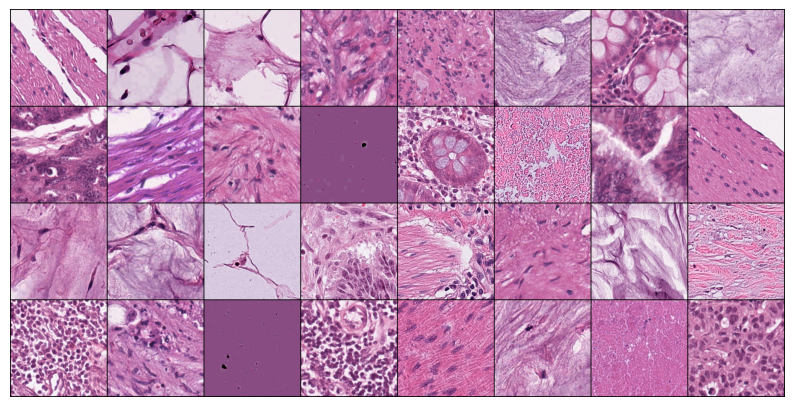

In [121]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(images.shape)
print(images.min(), images.max())  # Проверка диапазона значений
print(labels)

# Отображение изображений
img = utils.make_grid(images, nrow=8, padding=2)
np_img = img.cpu().numpy()
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(np_img, (1, 2, 0)))
plt.axis('off')
plt.show()

In [122]:
model = Model(
    model=SimpleCNN(num_classes=9),
    optimizer_fn=optim.Adam,
    optimizer_params={"lr": 0.001},
    scheduler_type="step",
    scheduler_params={"step_size": 5, "gamma": 0.5},
    log_dir=f"runs/model_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
)


EVALUATE_ONLY = False
if not EVALUATE_ONLY:
    model.train(train_loader, val_loader, epochs=20)
    model.save('best')
else:
    #todo: your link goes here
    model.load('best')

Using device cuda
Model initialized. Device: cuda
cuda:0


Epoch 1/20: 100%|██████████| 450/450 [00:07<00:00, 59.26it/s]


Epoch [1/20] - Training Loss: 0.7429, Accuracy: 74.53%


Evaluating: 100%|██████████| 113/113 [00:01<00:00, 99.31it/s] 


Validation Loss: 0.8250, Validation Accuracy: 70.83%
Saved new best model: best_model.pth


Epoch 2/20: 100%|██████████| 450/450 [00:07<00:00, 58.92it/s]


Epoch [2/20] - Training Loss: 0.4082, Accuracy: 86.37%


Evaluating: 100%|██████████| 113/113 [00:01<00:00, 102.12it/s]


Validation Loss: 2.8437, Validation Accuracy: 31.44%


Epoch 3/20: 100%|██████████| 450/450 [00:07<00:00, 59.24it/s]


Epoch [3/20] - Training Loss: 0.2925, Accuracy: 90.69%


Evaluating: 100%|██████████| 113/113 [00:01<00:00, 103.13it/s]


Validation Loss: 3.7889, Validation Accuracy: 34.58%


Epoch 4/20: 100%|██████████| 450/450 [00:07<00:00, 59.36it/s]


Epoch [4/20] - Training Loss: 0.2348, Accuracy: 92.26%


Evaluating: 100%|██████████| 113/113 [00:01<00:00, 100.46it/s]


Validation Loss: 1.6207, Validation Accuracy: 64.31%


Epoch 5/20: 100%|██████████| 450/450 [00:07<00:00, 59.21it/s]


Epoch [5/20] - Training Loss: 0.1975, Accuracy: 93.38%


Evaluating: 100%|██████████| 113/113 [00:01<00:00, 101.70it/s]


Validation Loss: 0.5345, Validation Accuracy: 81.39%
Saved new best model: best_model.pth


Epoch 6/20: 100%|██████████| 450/450 [00:07<00:00, 59.14it/s]


Epoch [6/20] - Training Loss: 0.1400, Accuracy: 95.26%


Evaluating: 100%|██████████| 113/113 [00:01<00:00, 102.34it/s]


Validation Loss: 0.4869, Validation Accuracy: 85.36%
Saved new best model: best_model.pth


Epoch 7/20: 100%|██████████| 450/450 [00:07<00:00, 58.84it/s]


Epoch [7/20] - Training Loss: 0.1253, Accuracy: 96.00%


Evaluating: 100%|██████████| 113/113 [00:01<00:00, 91.07it/s] 


Validation Loss: 0.8294, Validation Accuracy: 79.94%


Epoch 8/20: 100%|██████████| 450/450 [00:07<00:00, 58.38it/s]


Epoch [8/20] - Training Loss: 0.1166, Accuracy: 96.11%


Evaluating: 100%|██████████| 113/113 [00:01<00:00, 98.99it/s] 


Validation Loss: 0.3227, Validation Accuracy: 89.39%
Saved new best model: best_model.pth


Epoch 9/20: 100%|██████████| 450/450 [00:07<00:00, 58.67it/s]


Epoch [9/20] - Training Loss: 0.1109, Accuracy: 96.29%


Evaluating: 100%|██████████| 113/113 [00:01<00:00, 103.70it/s]


Validation Loss: 0.3654, Validation Accuracy: 89.14%


Epoch 10/20: 100%|██████████| 450/450 [00:07<00:00, 58.89it/s]


Epoch [10/20] - Training Loss: 0.1048, Accuracy: 96.64%


Evaluating: 100%|██████████| 113/113 [00:01<00:00, 99.37it/s] 


Validation Loss: 1.3717, Validation Accuracy: 74.03%


Epoch 11/20: 100%|██████████| 450/450 [00:07<00:00, 58.52it/s]


Epoch [11/20] - Training Loss: 0.0760, Accuracy: 97.65%


Evaluating: 100%|██████████| 113/113 [00:01<00:00, 102.39it/s]


Validation Loss: 0.1226, Validation Accuracy: 96.28%
Saved new best model: best_model.pth


Epoch 12/20: 100%|██████████| 450/450 [00:07<00:00, 58.60it/s]


Epoch [12/20] - Training Loss: 0.0809, Accuracy: 97.55%


Evaluating: 100%|██████████| 113/113 [00:01<00:00, 93.84it/s] 


Validation Loss: 0.1002, Validation Accuracy: 96.75%
Saved new best model: best_model.pth


Epoch 13/20: 100%|██████████| 450/450 [00:07<00:00, 59.41it/s]


Epoch [13/20] - Training Loss: 0.0667, Accuracy: 97.93%


Evaluating: 100%|██████████| 113/113 [00:01<00:00, 102.63it/s]


Validation Loss: 0.0954, Validation Accuracy: 96.67%
Saved new best model: best_model.pth


Epoch 14/20: 100%|██████████| 450/450 [00:07<00:00, 59.57it/s]


Epoch [14/20] - Training Loss: 0.0629, Accuracy: 97.91%


Evaluating: 100%|██████████| 113/113 [00:01<00:00, 100.36it/s]


Validation Loss: 0.1833, Validation Accuracy: 94.11%


Epoch 15/20: 100%|██████████| 450/450 [00:07<00:00, 59.45it/s]


Epoch [15/20] - Training Loss: 0.0656, Accuracy: 97.88%


Evaluating: 100%|██████████| 113/113 [00:01<00:00, 100.90it/s]


Validation Loss: 0.1251, Validation Accuracy: 95.69%


Epoch 16/20: 100%|██████████| 450/450 [00:07<00:00, 59.12it/s]


Epoch [16/20] - Training Loss: 0.0525, Accuracy: 98.47%


Evaluating: 100%|██████████| 113/113 [00:01<00:00, 100.78it/s]


Validation Loss: 0.0707, Validation Accuracy: 97.86%
Saved new best model: best_model.pth


Epoch 17/20: 100%|██████████| 450/450 [00:07<00:00, 59.14it/s]


Epoch [17/20] - Training Loss: 0.0499, Accuracy: 98.51%


Evaluating: 100%|██████████| 113/113 [00:01<00:00, 104.61it/s]


Validation Loss: 0.0858, Validation Accuracy: 97.00%


Epoch 18/20: 100%|██████████| 450/450 [00:07<00:00, 59.15it/s]


Epoch [18/20] - Training Loss: 0.0483, Accuracy: 98.52%


Evaluating: 100%|██████████| 113/113 [00:01<00:00, 101.62it/s]


Validation Loss: 0.0847, Validation Accuracy: 97.67%


Epoch 19/20: 100%|██████████| 450/450 [00:07<00:00, 59.14it/s]


Epoch [19/20] - Training Loss: 0.0480, Accuracy: 98.45%


Evaluating: 100%|██████████| 113/113 [00:01<00:00, 101.98it/s]


Validation Loss: 0.0745, Validation Accuracy: 97.64%


Epoch 20/20: 100%|██████████| 450/450 [00:07<00:00, 59.42it/s]


Epoch [20/20] - Training Loss: 0.0450, Accuracy: 98.64%


Evaluating: 100%|██████████| 113/113 [00:01<00:00, 99.95it/s] 

Validation Loss: 0.0801, Validation Accuracy: 97.22%


/tmp/ipykernel_3495478/327049586.py:177: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(path))
Evaluating: 100%|██████████| 113/113 [00:

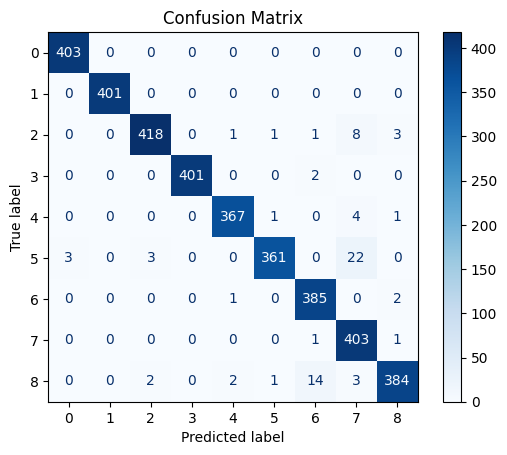

(0.07074448421898306, 97.86111111111111)

In [123]:
model.load('best_model.pth')
model.evaluate(val_loader, plot_conf_matrix=True)

In [ ]:
# load and fine tune on tiny dataset
d_train_tiny = Dataset('train_tiny')
len_img=len(d_train_tiny)
len_train=int(0.8 * len_img)
len_val=len_img-len_train

# Split Pytorch tensor
train_ts,val_ts=random_split(d_train_tiny,
                             [len_train,len_val]) # random split 80/20


In [ ]:
train_ts.transform=tr_transf
val_ts.transform=val_transf


In [ ]:
train_loader = DataLoader(train_ts, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ts, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
model_tiny = Model(
    model=SimpleCNN(num_classes=9),
    optimizer_fn=optim.Adam,
    optimizer_params={"lr": 0.01},
    scheduler_type="step",
    scheduler_params={"step_size": 5, "gamma": 0.5}
)

model_tiny.load('best_model.pth', val_loader)
model_tiny.train(train_loader, val_loader, epochs=10)


Пример тестирования модели на части набора данных:

In [124]:
predictions = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(predictions)], predictions, '10% of test')

Testing: 100%|██████████| 141/141 [00:01<00:00, 84.29it/s]

metrics for 10% of test:
	 accuracy 1.0000:
	 balanced accuracy 1.0000:



/root/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [ ]:
# model.load('best')

In [138]:
# test on 1 image 
img, lbl = d_test.random_image_with_label()
pred = model.test_on_image(img)
print(f'predicted class: {TISSUE_CLASSES[pred]}, true class: {TISSUE_CLASSES[lbl]}')


predicted class: TUM, true class: TUM


Пример тестирования модели на полном наборе данных:

In [139]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

Testing: 100%|██████████| 141/141 [00:01<00:00, 84.52it/s]

metrics for test:
	 accuracy 0.9816:
	 balanced accuracy 0.9816:


In [ ]:
class HeavyCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(HeavyCNN, self).__init__()
        self.features = nn.Sequential(
            # First block: Increased filters
            nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # Reduce size by 2

            # Second block: More filters
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # Reduce size by 2

            # Third block: Further increase filters
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # Reduce size by 2

            # Fourth block: Even more filters
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))  # Reduce to (1, 1) spatial size
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 2048),  # Heavily parameterized fully connected layers
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
# Instantiate the model
heavy_model = HeavyCNN(num_classes=9)

# Define optimizer and loss function
optimizer = optim.Adam(heavy_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
heavy_model.to(device)

# Train the model
model = Model(
    model=heavy_model,
    criterion=criterion,
    optimizer_fn=optim.Adam,
    optimizer_params={"lr": 0.001},
    scheduler_type="step",
    scheduler_params={"step_size": 5, "gamma": 0.5}
)

model.train(train_loader, val_loader, epochs=10)

Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [140]:

model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

/tmp/ipykernel_3495478/327049586.py:177: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(path))


Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


Testing: 100%|██████████| 3/3 [00:00<00:00, 12.63it/s]

metrics for test-tiny:
	 accuracy 0.9444:
	 balanced accuracy 0.9444:


Отмонтировать Google Drive.

In [ ]:
# drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru. 

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb 

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"